### Read Data

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

src_dir = os.path.abspath(os.path.join('..', 'src'))
sys.path.append(src_dir)

import requests
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils.config import settings

In [2]:
# Read Data
data = requests.get(settings.URL)
data = data.json()
data.keys()

dict_keys(['Meta Data', 'Time Series (5min)'])

In [3]:
data['Meta Data']

{'1. Information': 'Intraday (5min) open, high, low, close prices and volume',
 '2. Symbol': 'IBM',
 '3. Last Refreshed': '2025-05-21 19:55:00',
 '4. Interval': '5min',
 '5. Output Size': 'Full size',
 '6. Time Zone': 'US/Eastern'}

In [4]:
print(len(data['Time Series (5min)']))
data['Time Series (5min)']

3918


{'2025-05-21 19:55:00': {'1. open': '260.9100',
  '2. high': '261.3650',
  '3. low': '260.6500',
  '4. close': '261.3650',
  '5. volume': '83'},
 '2025-05-21 19:50:00': {'1. open': '260.9000',
  '2. high': '260.9000',
  '3. low': '260.9000',
  '4. close': '260.9000',
  '5. volume': '2'},
 '2025-05-21 19:45:00': {'1. open': '260.8100',
  '2. high': '260.8100',
  '3. low': '260.6500',
  '4. close': '260.6500',
  '5. volume': '80'},
 '2025-05-21 19:40:00': {'1. open': '261.4400',
  '2. high': '261.4400',
  '3. low': '261.4400',
  '4. close': '261.4400',
  '5. volume': '2'},
 '2025-05-21 19:35:00': {'1. open': '260.9100',
  '2. high': '260.9100',
  '3. low': '260.9100',
  '4. close': '260.9100',
  '5. volume': '3'},
 '2025-05-21 19:30:00': {'1. open': '260.8100',
  '2. high': '260.8100',
  '3. low': '260.8100',
  '4. close': '260.8100',
  '5. volume': '20'},
 '2025-05-21 19:25:00': {'1. open': '260.9100',
  '2. high': '261.4115',
  '3. low': '260.9100',
  '4. close': '261.4115',
  '5. volu

In [5]:
def flatten(data):
    flatten_dicts = []
    for timestamp, vals in data.items():
        flatten_dict = {name.split(' ')[-1].strip(): price for name, price in vals.items()}
        flatten_dict['timestamp'] = timestamp
        flatten_dicts.append(flatten_dict)

    return flatten_dicts

flatten_dicts = flatten(data['Time Series (5min)'])
df = pd.DataFrame(flatten_dicts).set_index('timestamp')
df.head()

,open,high,low,close,volume
timestamp,,,,,
2025-05-21 19:55:00,260.9100,261.3650,260.6500,261.3650,83
2025-05-21 19:50:00,260.9000,260.9000,260.9000,260.9000,2
2025-05-21 19:45:00,260.8100,260.8100,260.6500,260.6500,80
2025-05-21 19:40:00,261.4400,261.4400,261.4400,261.4400,2
2025-05-21 19:35:00,260.9100,260.9100,260.9100,260.9100,3


### EDA

In [6]:
df[df.columns] = df[df.columns].astype(float)
df.index = pd.to_datetime(df.index)
# Sort based on timestamp
df = df.sort_index()
df.head()

,open,high,low,close,volume
timestamp,,,,,
2025-04-22 04:00:00,237.0320,237.2009,235.9493,235.9493,142.0
2025-04-22 04:10:00,236.8036,236.8036,236.8036,236.8036,3.0
2025-04-22 04:15:00,235.7209,235.7209,235.7209,235.7209,5.0
2025-04-22 04:30:00,236.6049,236.6049,236.6049,236.6049,2.0
2025-04-22 04:45:00,236.7738,236.7738,235.8798,236.3864,49.0


In [7]:
# Data Quality Checks
df.isnull().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [9]:
df.duplicated().sum()

np.int64(12)

### Feature Engineering
**a. Price-Based Features**

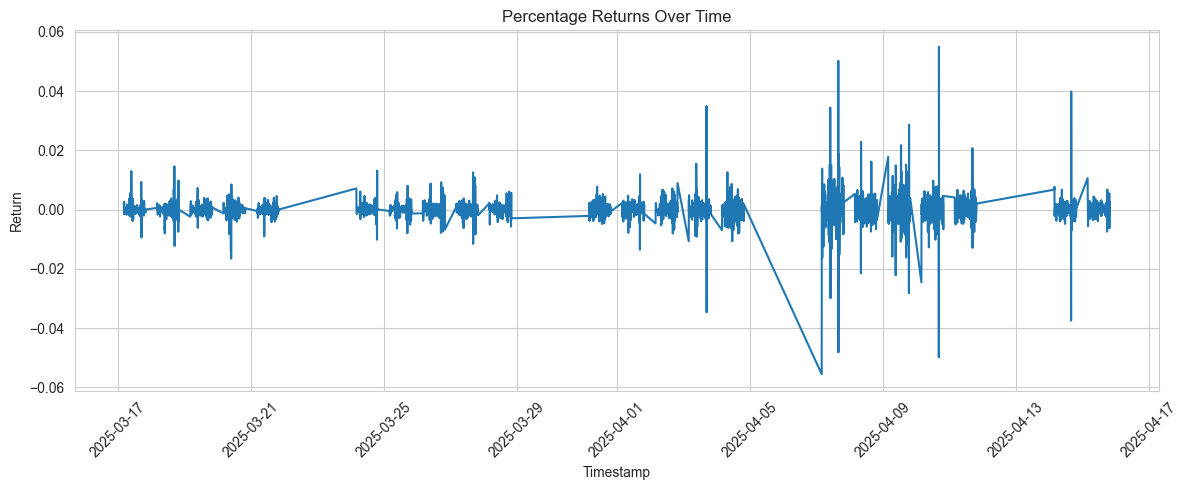

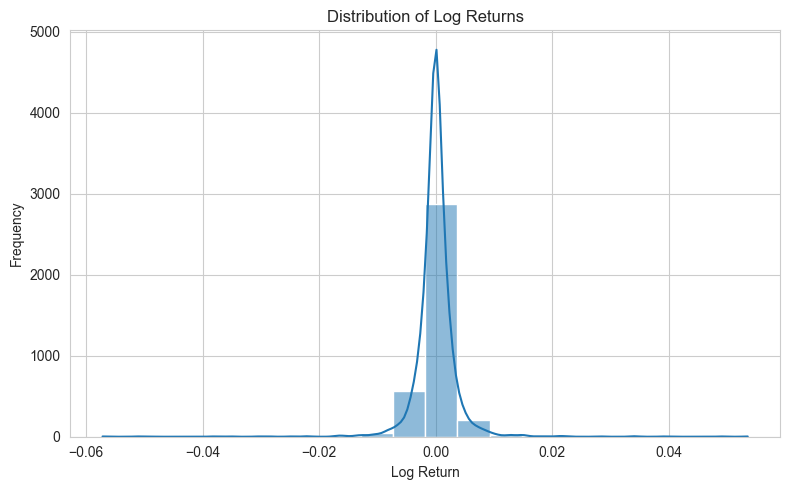

In [ ]:
# Returns and Log Returns
df['return'] = df['close'].pct_change()
df['log_return'] = np.log(df['close']).diff()

# Visualize time-series of returns
plt.figure(figsize=(12,5))
sns.lineplot(x=df.index, y=df['return'])
plt.title("Percentage Returns Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Return")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Distribution of log returns
plt.figure(figsize=(8,5))
sns.histplot(df['log_return'].dropna(), kde=True, bins=20)
plt.title("Distribution of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

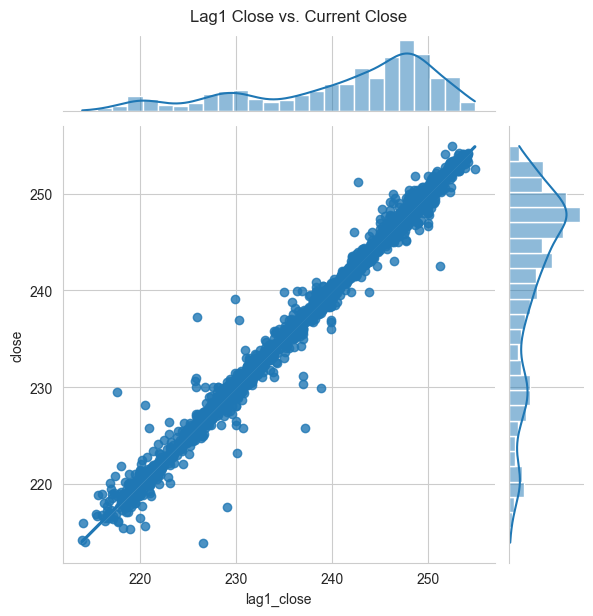

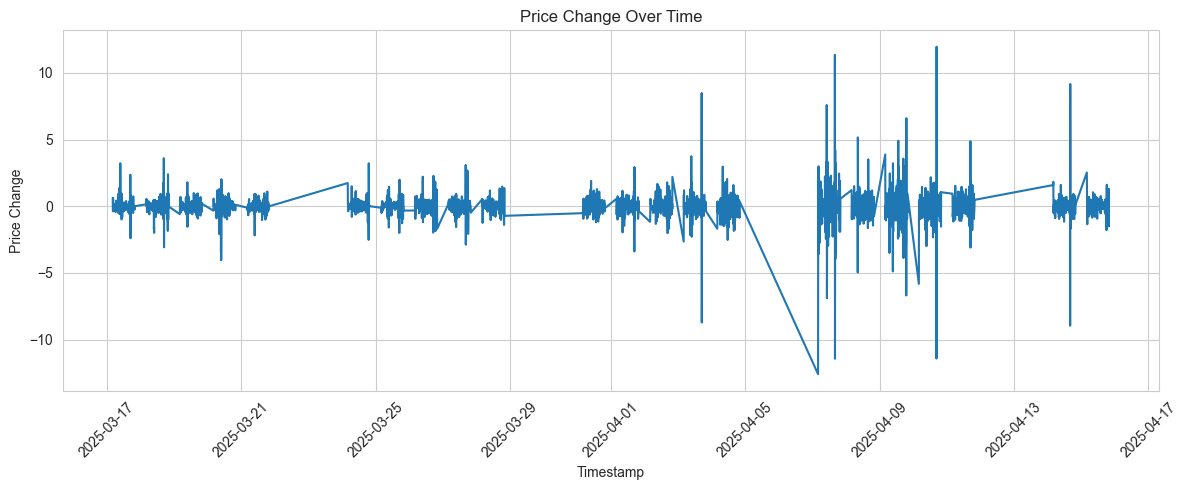

In [23]:
# Price Momentum and Lag Features
df['lag1_close'] = df['close'].shift(1)
df['price_change'] = df['close'] - df['lag1_close']

# JointPlot to see relationship between lagged close and current close
sns.jointplot(x='lag1_close', y='close', data=df.dropna(), kind="reg")
plt.suptitle("Lag1 Close vs. Current Close", y=1.02)
plt.show()

# Time series plot of price change
plt.figure(figsize=(12,5))
sns.lineplot(x=df.index, y=df['price_change'])
plt.title("Price Change Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Price Change")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

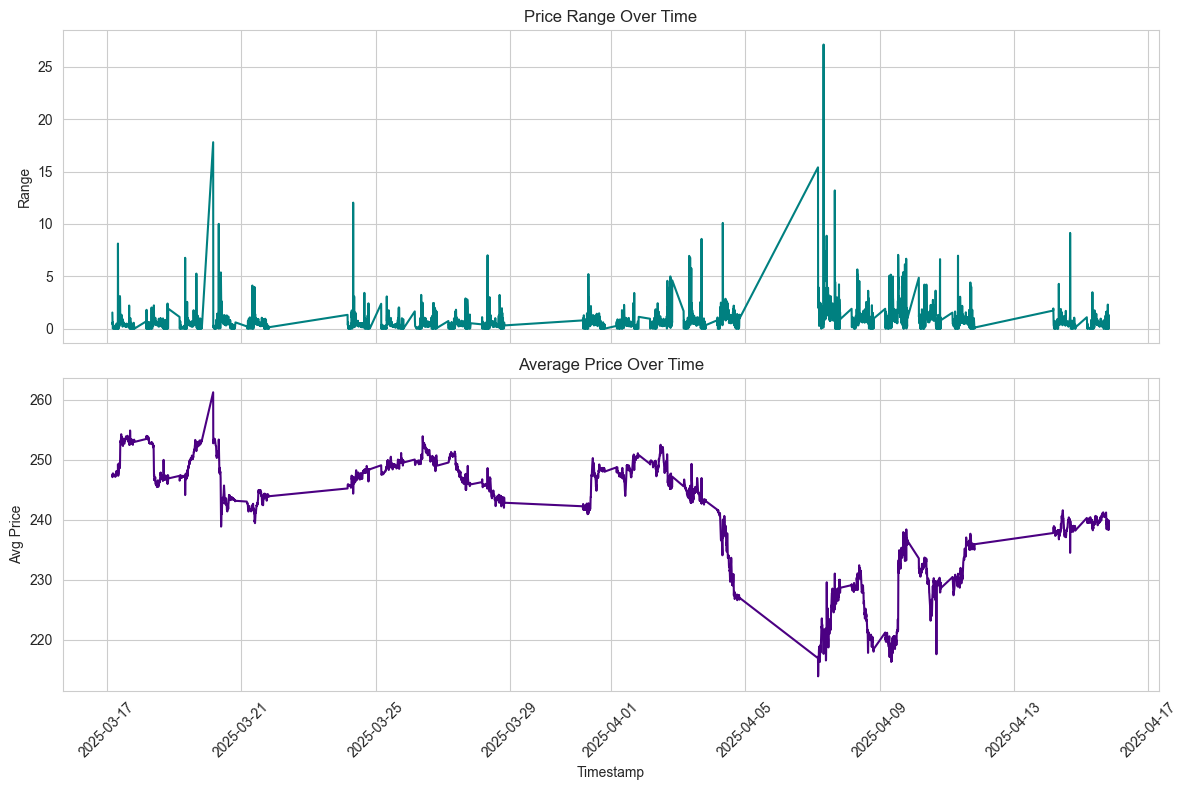

In [24]:
# Range and Average Price
df['range'] = df['high'] - df['low']
df['avg_price'] = df[['open', 'high', 'low', 'close']].mean(axis=1)

# Plot the range and average price over time
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)

sns.lineplot(x=df.index, y=df['range'], ax=ax[0], color="teal")
ax[0].set_title("Price Range Over Time")
ax[0].set_ylabel("Range")

sns.lineplot(x=df.index, y=df['avg_price'], ax=ax[1], color="indigo")
ax[1].set_title("Average Price Over Time")
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Avg Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

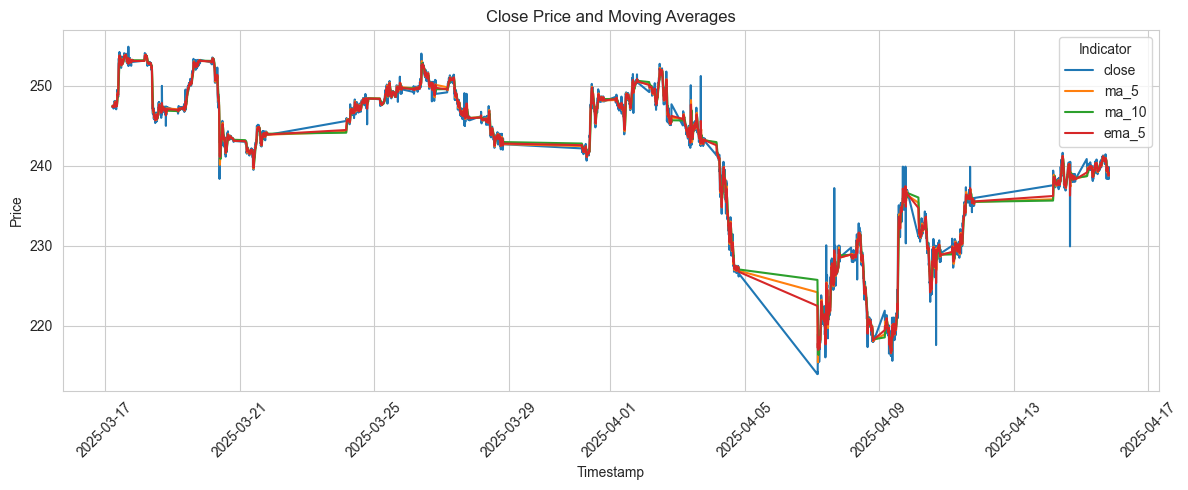

In [25]:
# Calculate moving averages for 5, 10, and 15 periods
df['ma_5'] = df['close'].rolling(window=5).mean()
df['ma_10'] = df['close'].rolling(window=10).mean()
df['ema_5'] = df['close'].ewm(span=5, adjust=False).mean()

# Melt the DataFrame for easier line plot comparisons with Seaborn
ma_df = df[['close', 'ma_5', 'ma_10', 'ema_5']].dropna().reset_index()
ma_df_melt = ma_df.melt(id_vars='timestamp', var_name='Indicator', value_name='Price')

plt.figure(figsize=(12,5))
sns.lineplot(x='timestamp', y='Price', hue='Indicator', data=ma_df_melt)
plt.title("Close Price and Moving Averages")
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

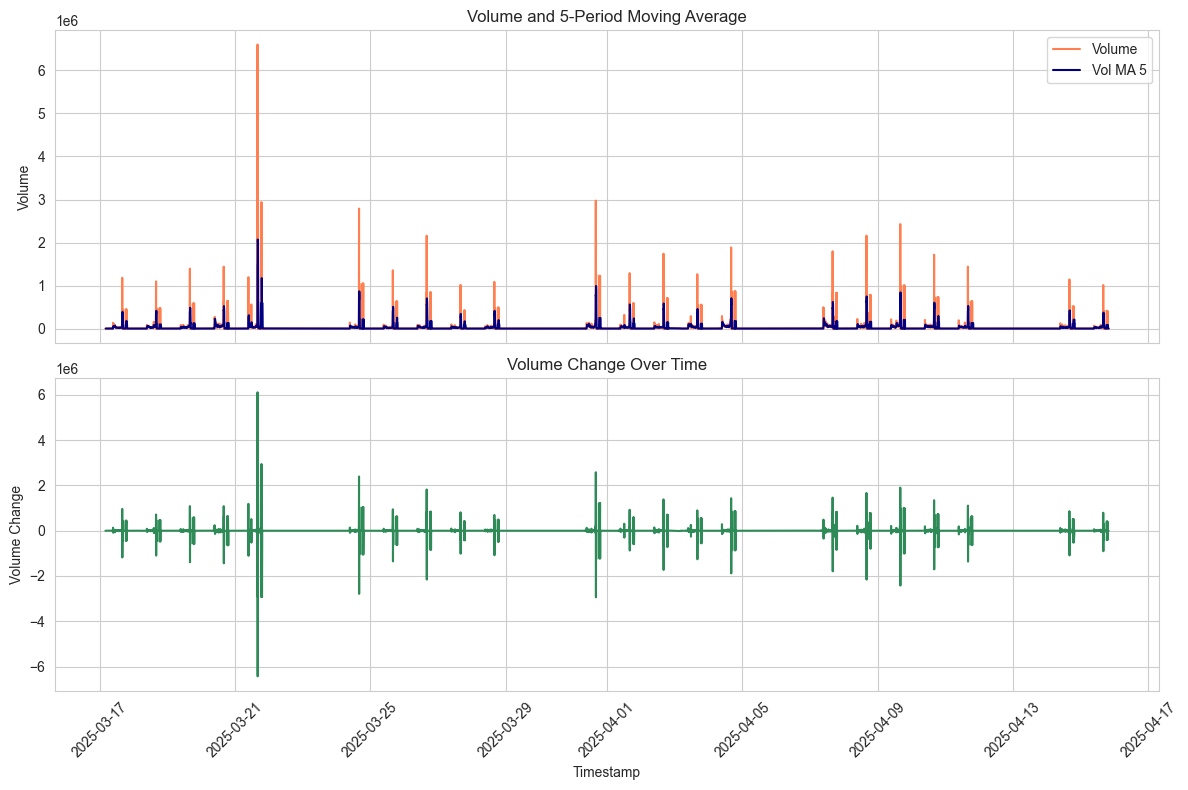

In [26]:
# Volume moving average (5 periods) and change
df['vol_ma_5'] = df['volume'].rolling(window=5).mean()
df['vol_change'] = df['volume'].diff()

# Visualize volume and volume moving average
fig, ax = plt.subplots(2, 1, figsize=(12,8), sharex=True)
sns.lineplot(x=df.index, y=df['volume'], ax=ax[0], label='Volume', color="coral")
sns.lineplot(x=df.index, y=df['vol_ma_5'], ax=ax[0], label='Vol MA 5', color="navy")
ax[0].set_title("Volume and 5-Period Moving Average")
ax[0].set_ylabel("Volume")

sns.lineplot(x=df.index, y=df['vol_change'], ax=ax[1], color="seagreen")
ax[1].set_title("Volume Change Over Time")
ax[1].set_xlabel("Timestamp")
ax[1].set_ylabel("Volume Change")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

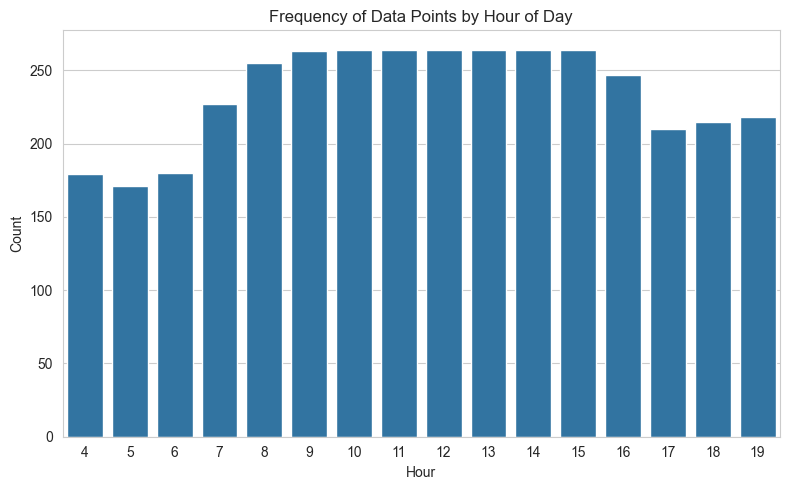

In [27]:
# Extract hour and minute of the day
df['hour'] = df.index.hour
df['minute'] = df.index.minute

# Visualize distribution of trading activity by hour using a bar plot
plt.figure(figsize=(8,5))
sns.countplot(x='hour', data=df.reset_index())
plt.title("Frequency of Data Points by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

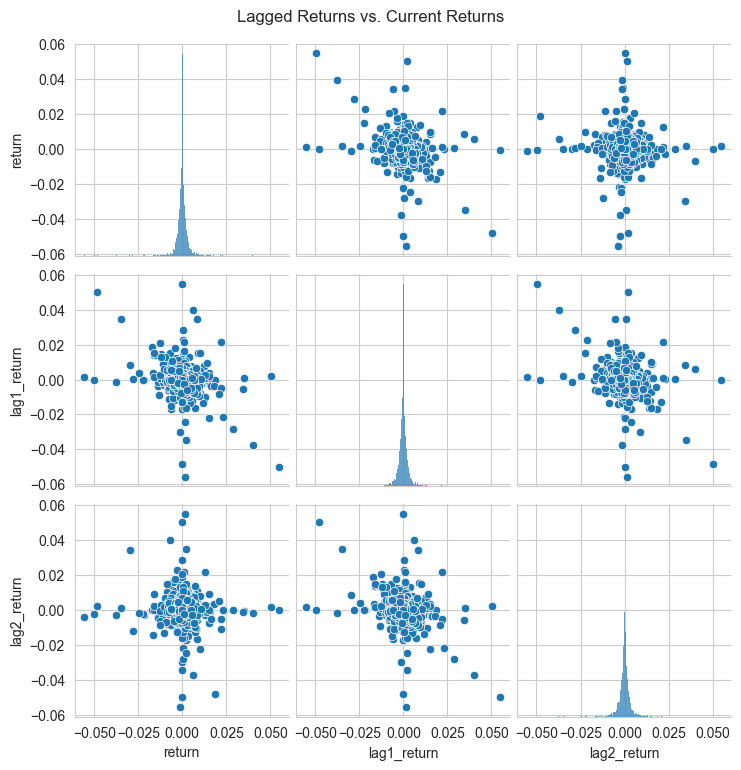

In [31]:
# Lagged Features
df['lag1_return'] = df['return'].shift(1)
df['lag2_return'] = df['return'].shift(2)

# Use pairplot to visualize the relationships
sns.pairplot(df[['return', 'lag1_return', 'lag2_return']].dropna())
plt.suptitle("Lagged Returns vs. Current Returns", y=1.02)
plt.show()

### Time Series Analysis and Diagnostics

ADF Statistic: -27.62964983956682, p-value: 0.0


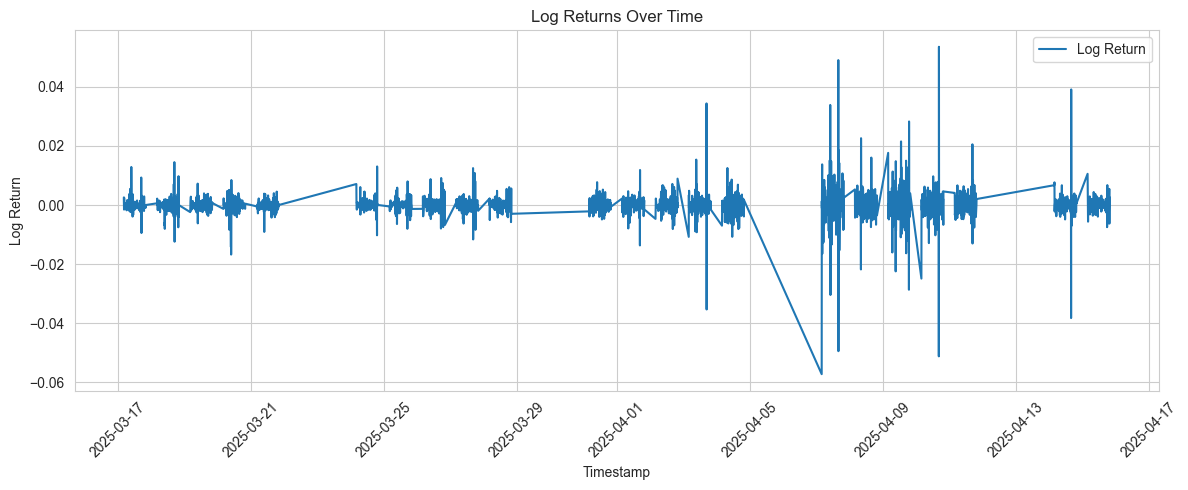

In [28]:
# Stationarity Testing: ADF Test Visualization
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['log_return'].dropna())
print(f"ADF Statistic: {adf_result[0]}, p-value: {adf_result[1]}")

# Plot log_return and its differenced series
plt.figure(figsize=(12,5))
sns.lineplot(x=df.index, y=df['log_return'], label="Log Return")
plt.title("Log Returns Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Log Return")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

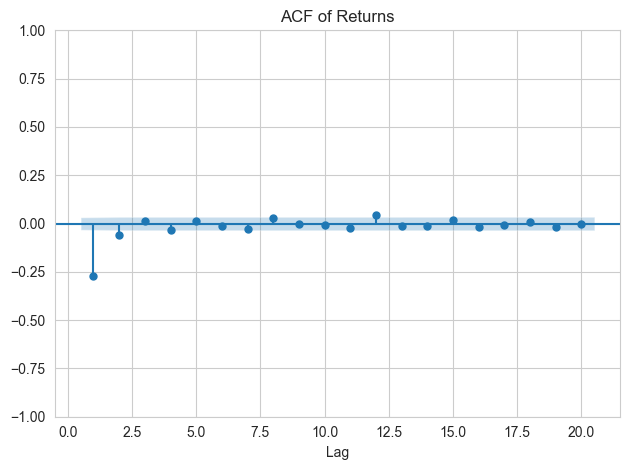

<Figure size 1200x500 with 0 Axes>

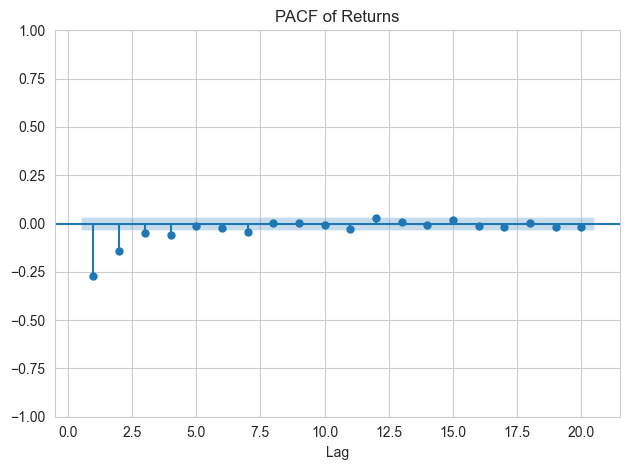

In [29]:
# Autocorrelation (ACF) and Partial Autocorrelation (PACF)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,5))
plot_acf(df['return'].dropna(), lags=20, zero=False)
plt.title("ACF of Returns")
plt.xlabel("Lag")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df['return'].dropna(), lags=20, zero=False)
plt.title("PACF of Returns")
plt.xlabel("Lag")
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

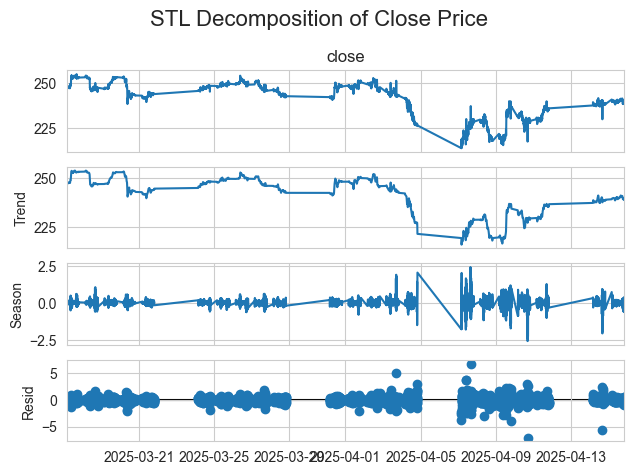

In [30]:
# Seasonal Decomposition
from statsmodels.tsa.seasonal import STL

# You may need to determine an appropriate period based on your dataset frequency
stl = STL(df['close'], period=5)  # For example, using a period of 5 minutes
result = stl.fit()

# Plot the decomposition
plt.figure(figsize=(12,8))
result.plot()
plt.suptitle("STL Decomposition of Close Price", fontsize=16)
plt.tight_layout()
plt.show()

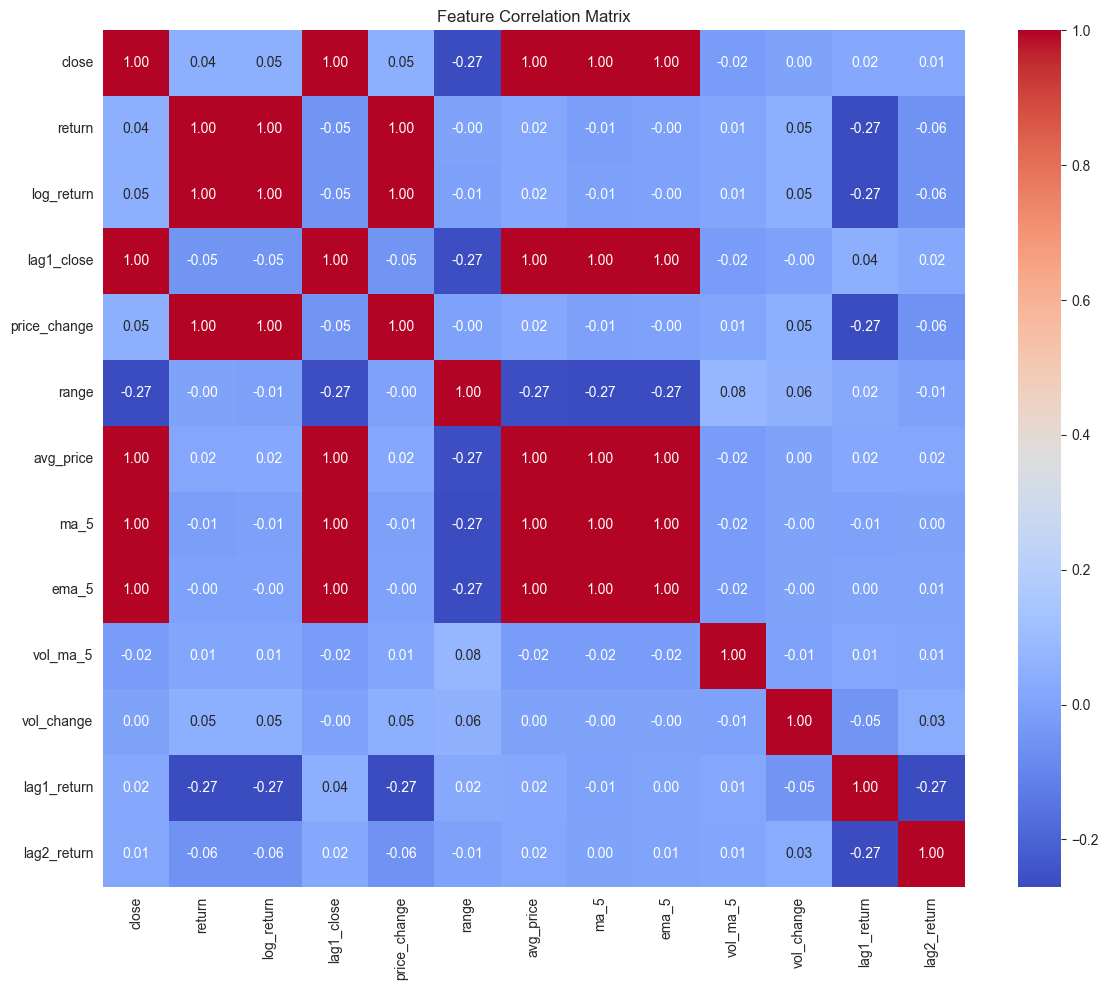

In [32]:
# Feature Correlation Analysis
# Select a subset of columns for analysis
features = ['close', 'return', 'log_return', 'lag1_close', 'price_change', 
            'range', 'avg_price', 'ma_5', 'ema_5', 'vol_ma_5', 'vol_change', 'lag1_return', 'lag2_return']

# Drop missing values, then compute correlation matrix
corr_matrix = df[features].dropna().corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

In [33]:
def step(func):
    def wrapper(*args, **kwargs):
        print(f"Executing: {func.__name__}")
        result = func(*args, **kwargs)
        print(f"Completed: {func.__name__}")
        return result
    return wrapper

@step 
def hello(txt):
    print(f"Hello {txt}")

hello("World")

Executing: hello
Hello World
Completed: hello
